## Project Report: Community detection and labeling in an Instagram Network

## 1. Aim of the project
Our objective is to detect communities in an Instagram Network using spectral clustering. The clusters can also be obtained and compared with the other graph based clustering methods mentioned in References which we give some comparisons with them as well.  Following the detection of communities, we aim to assign labels by using location information of users attached to photos of the users. 

## 2. Data Acquisition

We acquire our data from Instagram using a wrapper written on API (A library for Instagram API can be found [here](https://github.com/facebookarchive/python-instagram), we use forked version that can be found [here](https://github.com/somedanalytics/python-instagram-fixed)). Different users are nodes of network and edges are determined based on whether one of them liked a photo of other.
 
As Instagram API does not provide follower or following information, we cannot build user relationships based on “follow” connections. We have an indirect strategy to collect our network users, where we also employ Facebook API.
 
Before ending up with using Facebook API to find places in Lausanne, we tried different methods to gather locations. First, we used Instagram API's functionality that returns nearby places for given geolocation. However, Instagram API tends to return places which are far from geolocation given, sometimes even returns places in different countries. In order to fix that problem, intial coordinate being the center, we construct a rectangular grid covering whole Lausanne and call Instagram API to find nearby places for each of these grid points. Places returned for each of these grid points are collected in a list, where each place occurs single time (no repetitions). However, when we examined list of places, we again encountered places far from Lausanne. Secondly, we tried Google Places API for the same aim. However, we were unable to match places in Google Places API  (which employs names of places as id) and Instagram API (which uses numerical id to indicate difference places) as there is no correspondence between them. Lastly, we ended up using Facebook API. Initially, we pick some locations in Lausanne using Facebook API, leveraging the fact that it can return the places that are nearby of a given geographical coordinate, and with a specified category such as cafe, restaurant, nightlife etc. The most prominent advantage of Facebook API is, place ids returned have one-to-one correspondence with Instagram's place ids. Also, unlike Instagam API it works reliably and returns many places which are really near given coordinate and within given radius. We make a list of places returned by Facebook API which are located in Lausanne (eg; we picked the initial coordinate as "lat": 46.519962, "lon": 6.633597) with category of either entertainment or food. The number of places that are returned by Facebook API is 277 for entertainment type and 821 for food type. After acquiring list of places, we used Instagram API's functionality that returns place id in Instagram given place id in Facebook. At the end, we had places within or near Lausanne with their names and ids compatible with Instagram API.

Below you can see gif of data acquistion process. Starting from a place (e.g. Ouchy) Instagram users who shared a photo in Ouchy are inserted in network. After all users who shared a photo in Ouchy are inserted in network.

![data_acquistion_gif](img/data_acqusition.gif)
 
Using the wrapper on Instagram API, we gather users who added any of these places in their photos in the last 1 month and thus create the network using these users as nodes. Then, photos of each user shared in last 100 weeks are examined and users who liked these photos are added to network as new nodes, provided that they are not already in the network. In other words, Instagram users who liked the photos, that shared in the last 100 weeks, of users that are already in the network are found and added to the network as new nodes. The network is expanded repeating this step for several times. That expansion step is done 3 times and then all the nodes of network are acquired and fixed. After all of these steps, we end up with 43002 number of nodes each corresponding to different. For the graph with edges constructed using likes, edges are specified while gathering the users. We add an edge between two nodes if at least one of the users liked at least one photo of the other. For that case 141389 edges are present in the network, where number of connected componenets is 1 and number of self-loops is 0.

Below the graph is visualised using [graphtool](https://graph-tool.skewed.de/). Code snippet used for taking the data from neo4j graph database and visualising using graphtool is provided as well.

![All data](img/all_data.jpg)


The resulting network is stored using neo4j graph database (more information can be found [here](https://neo4j.com/)) with all necessary information present. The database can be reached [here](http://35.158.233.131:7474/browser/). (The password is: qqwweerr)

Specifically, instances in the neo4j graph database can be:
* order
* community
* instagram user
* location. 

These instances have property types.
* Order has algorithm property, denoting which algorithm is run in that order. If available, parameters of the algorithm is stored by that property as well.
* Instagram user has layer property, denoting in which step of user acquisition the node is added to network.
* Each node has name property. For Instagram users, it is same as Instagram id returned by Instagram API. For locations, it is same as id returned by Facebook API.
* Location has locationName property, denoting the name of location returned by Facebook API.

These different types of instances can have various relations between them. 
* Order creates communit(-y/-ies). 
* Community can be subcommunity of other communit(-y/-ies).
* Community is processed by order.
* Instagram user is member of communit(-y/-ies).
* Instagram user can like another Instagram user.
* Instagram user can visit location.

Below there is an example from neo4j database that we employ. Instances are denoted as circles. Orange instances denote communities, purple instances denote Instagram users and pink instance denote place. Arrows denote relations between instances. For example, Instagram users are member of (sub)communities. Some (sub)communities are subcommunity of other (sub)communities. Instagram user visited a place.

For detailed code of data acquisition process, please refer to following notebooks:

* Create Network from Multiple Source.ipynb
* Merge Networks.ipynb
* Upload Huge Graph to Neo4j.ipynb
* Upload Locations.ipynb



![neo4j Graph Example](img/neo4j_example.png)



As data we gathered is huge, running the algorithms becomes very slow. In order to quickly get results and analyse results in more efficient and understandable manner, we decided to work on subsample of data. Sampling such huge dataset with each node having same probability to be sampled in does not make sense, as in that case we could not ensure connectedness. Also, resulting network is very likely to be very sparse. In order to ensure connectedness and prevent such high degree of sparsity, we decided to first cluster data with a fast algorithm and then work on resulting clusters. In our literature search, we encountered [louvain clustering algorithm](https://perso.uclouvain.be/vincent.blondel/research/louvain.html), which is one the fastest algorithm for clustering huge datasets, and clustered the whole data we gathered. The implementation we used for louvain algorithm can be found [here](https://github.com/taynaud/python-louvain). Results are uploaded to neo4j graph database and using following code snippet we can easily take data of one of the resuling clusters generated by louvain alogorithm and run our algorithms on subset of whole data.

![database](img/load_data.png)

### 2.1 Data Cleaning
For the network which edges are constructed using likes information, we remove the users we gathered in the last hop (outer shell of the network) to be sure that we keep the inner connections between users.

## 3. Clustering 

### 3.1 Spectral Clustering

In [1]:
import SpectralClustering as sc
from GraphDatabase import Database
import networkx as nx
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter

%matplotlib inline

### 1. Pull a Network from the Database we created apriori

In [2]:
db = Database()
parentComid = 17
G = db.get_community(parentComid)
print('{} nodes, {} edges'.format(G.number_of_nodes(), G.number_of_edges()))
print('Number of connected componenets: {}'.format(len(list(nx.connected_component_subgraphs(G)))))
print('Number of self-loops: {}'.format(G.number_of_selfloops()))

1357 nodes, 2858 edges
Number of connected componenets: 1
Number of self-loops: 0


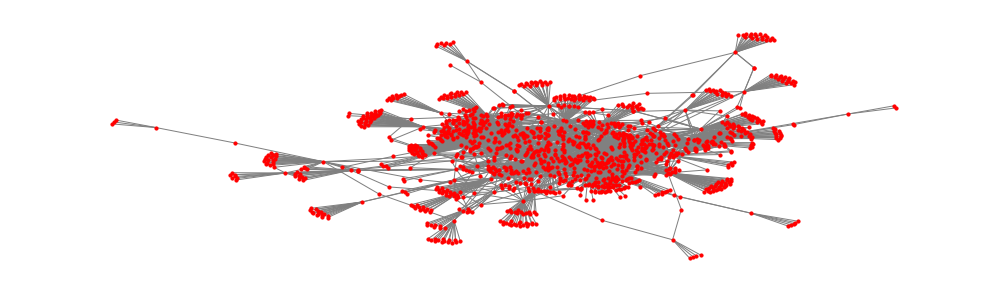

In [3]:
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (17, 5)
pos = nx.spring_layout(G)
ax = plt.subplot()
nx.draw(G, pos=pos,node_size=10, edge_color="gray")
ax.figure.savefig("sc_community_17.pdf", bbox_inches = "tight")

In the spring layout, we can observe some root users which are acquired in the prior layers in the network, and the users composing the border of the network, in the position of children of the root users, which are obtained in the later acquisition layers of the network.

### 2. Apply Spectral Clustering on the network

In [4]:
# Get the adjacency matrix of the graph
Adj = nx.adjacency_matrix(G).asfptype()
# use normalized Laplacian for clustering
n_cluster = 3
L, embedding, labels = sc.SpectralClustering(Adj.toarray(),Nc=n_cluster, lap_type='normalized')

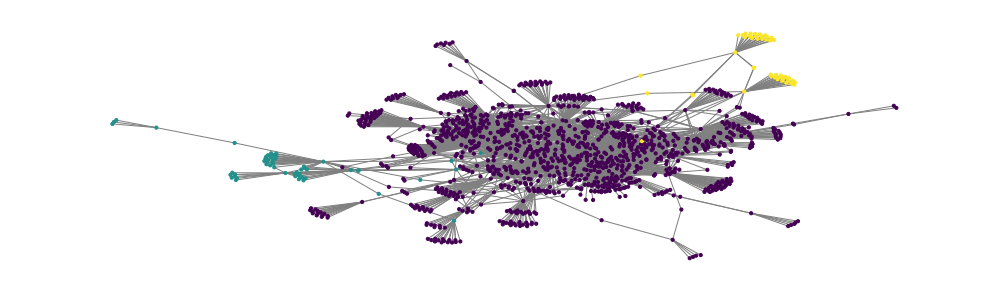

In [5]:
# Visualize the clustering result
ax = plt.subplot()
nx.draw(G,pos=pos, node_color=labels,node_size=10, edge_color="gray")
ax.figure.savefig("sc_community_17_nc_3.pdf", bbox_inches = "tight")

In [6]:
for label in  range(n_cluster):
    print('Cluster-{} has {} elements.'.format(label, labels.tolist().count(label)))

Cluster-0 has 1256 elements.
Cluster-1 has 55 elements.
Cluster-2 has 46 elements.


#### 2.1 Seperate the clusters to observe the inter-connections between them

In [7]:
# get the position of vertices in spring layout
posarray= np.asarray(list(pos.values()))
posarray.shape

(1357, 2)

In [8]:
# Shift the position of second community vertices
for label in  range(1,n_cluster): #keep the first cluster in its original position
    shift_n = (label-0.1)//4 +1
    if label % 4 == 1: #shift to right
        posarray[labels==label,0] = posarray[labels==label,0] + shift_n
    elif label % 4 == 2: #shift to left
        posarray[labels==label,0] = posarray[labels==label,0] - shift_n
    elif label % 4 == 3: #shift to down
        posarray[labels==label,1] = posarray[labels==label,0] + shift_n
    elif label % 4 == 0: #shift to up
        posarray[labels==label,1] = posarray[labels==label,0] - shift_n
# Construct a new position dictionary
dictpos = dict(zip(G.node.keys(), posarray))

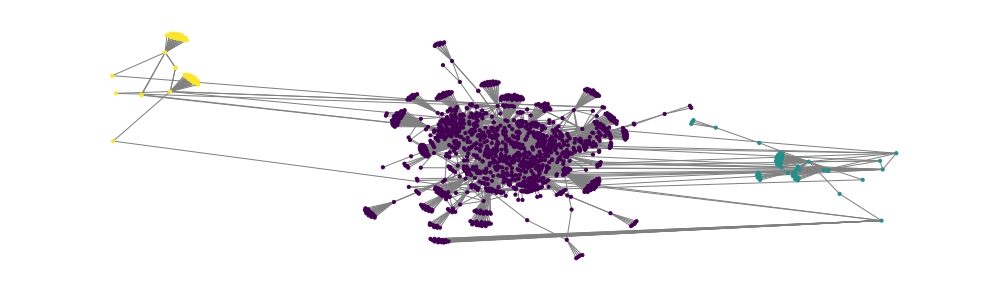

In [9]:
ax = plt.subplot()
nx.draw(G,pos=dictpos, node_color=labels,node_size=10, edge_color="gray")
ax.figure.savefig("sc_community_17_nc_3_shifted.pdf", bbox_inches = "tight")

#### Save the result to the database

Using the code below we store clustering results in neo4j graph database, including parent id of community and textual description of procedure.

In [10]:
# Create a dictionary fo the clustering result
community_result = dict(zip(G.node.keys(), labels))

In [11]:
#Database return an order number for the comunnity detection in the network having the parentComid
order = db.insert_community_analysis(community_result, parentComid,'spectralClustering_c:3_normalized_eda')

#### 2.2 Show the hub nodes in each cluster and their user id

Max degree of Cluster-0 is 232.0, and it has 1 hub nodes whose ids: 
 [3260673465]
Max degree of Cluster-1 is 31.0, and it has 1 hub nodes whose ids: 
 [1571360982]
Max degree of Cluster-2 is 25.0, and it has 1 hub nodes whose ids: 
 [5690332]


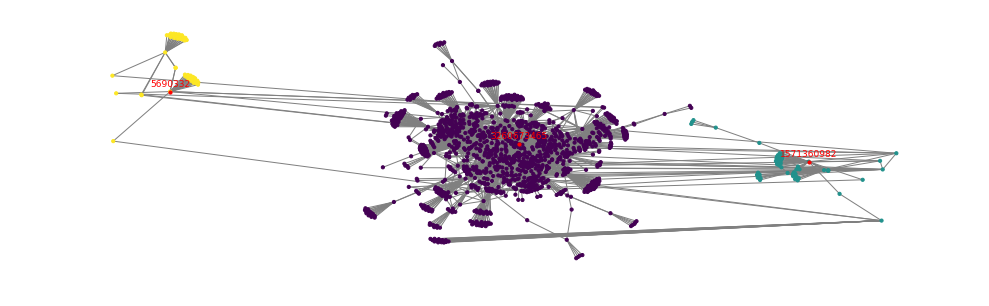

In [12]:
# Examine the degree distribution to discover the hub nodes in each cluster
# Then the hub nodes in each clutser will be colored in red
ax = plt.subplot()
nx.draw(G,pos=dictpos, node_color=labels,node_size=10, ax=ax, edge_color="gray")
degrees = Adj.toarray().sum(0)
for label in range(n_cluster):
    max_deg = degrees[labels == label].max()
    hub_idx= np.nonzero(np.logical_and(labels==label, degrees==max_deg))[0]
    hub_ids= [G.nodes()[i] for i in hub_idx]
    print('Max degree of Cluster-{} is {}, and it has {} hub nodes whose ids: \n {}'.format(label,max_deg,hub_idx.size,hub_ids))
    nx.draw_networkx_nodes(G, pos=dictpos, nodelist=hub_ids, node_color='r',node_size=10,ax=ax);
    for idx in hub_idx:
        x, y = posarray[idx]
        plt.text(x, y+0.02, s=str(G.nodes()[idx]), horizontalalignment='center', fontsize=9, color = 'r');
ax.figure.savefig("sc_community_17_nc_3_shifted_hub.pdf", bbox_inches = "tight")

We can see the hub nodes belonging to Cluster-1 (green) and Cluster-2 (yellow) are connecting the nodes from the other clusters, which makes the community detection even harder. Hence, for the labeling of these communities, we should discard their end-point information and instead we should focus on the other nodes which are more representative for each community.

#### 2.3 Observe the Sparsity Pattern of the Re-ordered Adjacancy Matrix

In [13]:
# re-order the nodes such that the ones having same cluster will come succesively
order_ind = np.argsort(labels) #indice numbers for ordering the adjacency matrix
ordered_adj = Adj[order_ind][:,order_ind] #re-ordered adjacency matrix

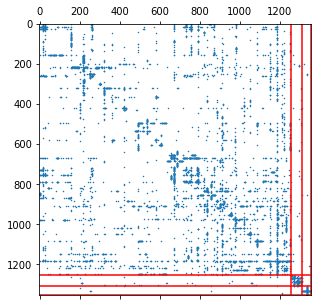

In [14]:
ax = plt.subplot()
ax.spy(ordered_adj,markersize=0.5);
cut_n = 0
for label in range(n_cluster):
    cut_n = cut_n + labels.tolist().count(label)
    line = mpl.lines.Line2D((cut_n, cut_n), (0, G.number_of_nodes()),color='r')
    ax.add_line(line)
    line = mpl.lines.Line2D((0, G.number_of_nodes()), (cut_n, cut_n),color='r')
    ax.add_line(line);
ax.figure.savefig("community_17_nc_3_adj.pdf", bbox_inches = "tight")

By looking at the sparsity pattern of the ordered adjacency matrix, especially the block belonging to the last cluster (Cluster-2), we can see that the spectral clustering algorithm is succesful to minimize the inter-connections between clusters. Cluster-2 is well separated from the the other clusters since it has dense inner connections and very sparse inter connections with the other ones. On the other hand, we see that Cluster-0 and Cluster-1 have more connected to each other. Hence, we can comparatively claim that we obtained a more qualified community detection result by distinguishing Cluster-2 users.

### Choose the representative nodes and Locations for the community

Alternatively, we propose the below community labeling method for the clusters we obtained.

In [15]:
#Get the locations attached with each user
info_user = db.get_visited(parentComid)

In [16]:
# Construct new dictionary to store the user visit information
loclist = [] # list to store the location id visited for each user
Place_dict = dict() # stores the LocationId/placeName mapping
Loc_dict = dict((key, list()) for key in G.node)
for info in info_user:
    user_id = info['Instauser']
    loc_id = info['LocationId']
    Loc_dict[user_id].append(loc_id)
    # Also assign the LocationId/placeName mapping
    Place_dict[loc_id] = info['placeName']

Max page-rank nodes and their locations for Cluster-0 are: 
 [3260673465] at D! Club - Lausanne
Most common place for Cluster-0 is Lausanne, Switzerland with 4.697452229299364 percent attendance from the users
Max page-rank nodes and their locations for Cluster-1 are: 
 [1571360982] at Café de Grancy
Most common place for Cluster-1 is Lausanne, Switzerland with 5.454545454545454 percent attendance from the users
Max page-rank nodes and their locations for Cluster-2 are: 
 [514563397] at Santorini Heights
Most common place for Cluster-2 is Perle-du-Lac with 2.1739130434782608 percent attendance from the users


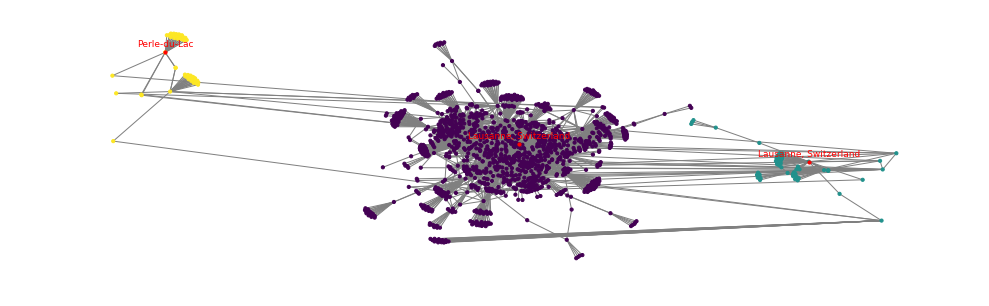

In [17]:
# Create a dictionary fo the clustering result
community_result = dict(zip(G.node.keys(), labels))# Then the hub nodes in each clutser will be colored in red
ax = plt.subplot()
nx.draw(G,pos=dictpos, node_color=labels,node_size=10, ax=ax, edge_color="gray")
degrees = Adj.toarray().sum(0)
for label in range(n_cluster):
    #get community user ids
    com_ids= [G.nodes()[i] for i in np.nonzero(labels==label)[0]]
    # get the pagerank values for the community users
    pageRank_dict = nx.pagerank(G.subgraph(com_ids))
    # find the nodes whose pagerank value is the maximum
    max_nodes = [k for k, v in pageRank_dict.items() if v == max(pageRank_dict.values())]
    place_name = Place_dict[Loc_dict[max_nodes[0]][0]]
    print('Max page-rank nodes and their locations for Cluster-{} are: \n {} at {}'.format(label,max_nodes, place_name))
    nx.draw_networkx_nodes(G, pos=dictpos, nodelist=max_nodes, node_color='r',node_size=10,ax=ax);
    # search for the most common place visited by the community users
    # merge location id list for the community users
    locList = []
    [ locList.extend(Loc_dict[k]) for k in com_ids];
    Loc_cnt = Counter(locList)
    cmnPlace_id, count = Loc_cnt.most_common(1)[0]
    place_name = Place_dict[cmnPlace_id]
    attendance = count/len(com_ids)*100
    print('Most common place for Cluster-{} is {} with {} percent attendance from the users'.format(label,place_name,attendance))
    for node in max_nodes:
        x, y = dictpos[node]
        plt.text(x, y+0.02, s=place_name, horizontalalignment='center', fontsize=9, color = 'r');
ax.figure.savefig("community_17_nc_3_shifted_hub_location.pdf", bbox_inches = "tight")

In this visualization, we showed the nodes whose page rank value is the most among their community users in red. We also put the text label on them as the name of the place that is mostly visited by the community users.

For each community, we indicate the user whose page-rank value is the highest in the community. That value is computed as if other communities do not exist. Otherwise, connections with other communities tend to dominate and especially for smaller clusters "hub" node tends to be around the edge of the cluster. We label the community as the most visited place among the users in that cluster. However, for different clusters the most visited place might be the same. In that case, that label is assigned to cluster with highest percentage of attendance to that particular place. Other communities are labeled with rest of the places. In that way, we ensure that labels of clusters are different. Other than examining label of clusters, another way to compare and constrast different clusters is comparing attendance of users in that cluster to different places.

### 3.3 Comparison of Clustering Results obtained from different methods

Among different clustering results for the same network data, we can make comparisons between them in terms of a notion of similarity. The similarity measure we have adopted considers the involvement of an arbitrary node-pair in the same cluster. In other words, it rates the clustering results that are likely to put the same of set of nodes together as more similar.

Let the clustering results whose similarity to be compared be $Cr_1$ and $Cr_2$. We can formulate the similarity between them as follows;
$$
similarity = \frac{n_{intersection}}{\sqrt{n_{\text{pairw comb Cr1}} \cdot n_{\text{pairw comb Cr2}}}}
$$

where $n_{intersection}$ is the number of node pairs which are commonly occured in the same cluster in both of the clustering results, and then, $n_{\text{pairw comb Cr2}}$ and $n_{\text{pairw comb Cr2}}$ are the number of different node pair combinations occuring the same cluster independently based on $Cr_1$ and $Cr_2$ respectively. This similarity measure is always between [0,1], where it is calculated as 0 for the case of null common space, whereas it returns 1 for the result of identical cluster sets.

In order to compare two clustering results, which does not have the same number of clusters, Newman modularity is used [4]. The community result with the higher number of clusters are merged according to the modularity measure. In other words, if we have a number of clusters, by merging every possible pair of clusters in this clustering result, we get a set of modularity measures. We merge the clusters which gives the maximum modularity measure. This procedure will be repeated until both results have the same number of clusters, then the similarity measure of two methods will be calculated as stated above.

Below, there is demonstration for how we merge pair of clusters regarding their modularity scores. In the gif, each circle corresponds to different cluster. Black ellipse shows current pair of clusters to merge. (Colours does not indicate any information for our purposes here)

![video](img/giphy.gif)

**Girvan-Newman** algorithm is one of the most popular algorithms used for community detection. It is based on the measures of edge centrality, which estimates the importance of edges. Below it is possible to see the steps of the algorithm [2]:

1. Computation of the centrality for all edges
2. Removal of the edge with largest centrality
3. Recalculation of centralities
4. Iteration of the cycle from Step 2.

In the project, girvan_newman function from network is used, which was iterated in order to have 7 clusters. The graph plot of Girman-Newman algorithm with 7 clusters on the network from Neo4J database with parent community ID 17 is provided on Comparison part, whose similarities with other methods are calculated and explained.

**Louvain** algorithm is one of the fastest community detection algorithm that can work on huge datasets. The method is a greedy optimization method that attempts to optimize the "modularity" of a partition of the network (modularity is defined here). The optimization is performed in two steps. First, the method looks for "small" communities by optimizing modularity locally. Second, it aggregates nodes belonging to the same community and builds a new network whose nodes are the communities. These steps are repeated iteratively until a maximum of modularity is attained and a hierarchy of communities is produced. Although the exact computational complexity of the method is not known, the method seems to run in time O(n log n) with most of the computational effort spent on the optimization at the first level. Exact modularity optimization is known to be NP-hard. More details can be found [here](https://perso.uclouvain.be/vincent.blondel/research/louvain.html).

In the project, Louvain algorithm is used to cluster the data and results are compared with the clustering results of other methods. Also, whole data is clustered by Louvain algorithm initially and the resulting clusters are stored in neo4j graph database. We worked on those resulting clusters of Louvain algorithm, as whole data is huge and running our methods on that is computationally intensive.

**Stochastic Block Model** algorithm can detect the typical pattern of “community structure”, i.e. when nodes are connected mostly to other nodes of the same group. More details can be found [here](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html#the-stochastic-block-model-sbm). In the project we used Graph-tool package and compared the results with other clustering methods. Please refer to following notebooks: "Conclusions+-+%28graph-tool%29.ipynb", "Comparisons-Conclusions.ipynb", "Comparison+Workspace.ipynb".

### 3.4 Comparison
For the same network, several clustering methods shall be applied and their community detection results can be compared by:

1. The nodes can be labeled wrt to clustering result (label of the nodes in the same cluster will be same). We can compute a smoothness score yielded by the clustering result. Let's say f_1 store labels of spectral clustering and f_2 is for greedy clustering. Compare f_1'Lf_1 and f_2'Lf_2, the smoother one will be computed with a smaller score. Number of clusters and the assigned labels may have a crucial role in the result.

2. Visualize the sparsity pattern (plot spy) of the ordered Adjacency matrix (wrt clustering result). We expect to see more connections in clusters and less connection inter clusters.

3. Visualize the communities by visualizing the graph --> G.set_coordinates('community2D') may provide another visual comparison btw clustering methods.

4. Check the paritition measuring algorithms within Networkx.


Below, visualisations of cluster results for different algorithms on same data are presented. Also, similarity score that we calculated is given at the bottom of each visualisation.

![comparison_1](img/comparison_1.jpg)
![comparison_2](img/comparison_2.jpg)
![comparison_3](img/comparison_3.jpg)
![comparison_4](img/comparison_4.jpg)
![comparison_5](img/comparison_5.jpg)

## 4. Conclusion

As it can be seen from the table below, Spectal clustering and Girvan-Newman methods give the most similar clustering results. Other than these two, any pair of methods do not give significantly similar results. 

|            Similarity Score            | Girvan-Newman (# cluster = 7) | Stochastic Block Model (# cluster = 7) | Spectral Clustering (# cluster = 7) | Louvain (# cluster = 15) |
|:--------------------------------------:|:-----------------------------:|:--------------------------------------:|:-----------------------------------:|:------------------------:|
|      Girvan-Newman (# cluster = 7)     |               0               |                  0.583                 |                0.941                |           0.347          |
| Stochastic Block Model (# cluster = 7) |             0.583             |                    0                   |                0.595                |             -            |
|   Spectral Clustering (# cluster = 7)  |             0.941             |                  0.595                 |                  0                  |           0.335          |
|        Louvain (# cluster = 15)        |             0.347             |                    -                   |                0.335                |             0            |

## 5. References

[1] Ng, Andrew Y., Michael I. Jordan, and Yair Weiss. "On spectral clustering: Analysis and an algorithm." Advances in neural information processing systems. 2002.
APA

[2] Fortunato, Santo. "Community detection in graphs." Physics reports 486.3 (2010): 75-174.
APA	

[3] Blondel, Vincent D., et al. "Fast unfolding of communities in large networks." Journal of statistical mechanics: theory and experiment 2008.10 (2008): P10008.

[4] Clauset, Aaron, Mark EJ Newman, and Cristopher Moore. "Finding community structure in very large networks." Physical review E 70.6 (2004): 066111.
